# Predicting TCR–Neoantigen Binding with ML models (XGBoost)

#### Import Libraries

In [1]:
import os
import scanpy as sc
import scipy.io
import scipy.sparse as sp
import pandas as pd 
import numpy as np
import anndata
import matplotlib.pyplot as plt
import seaborn as sns

#### Load pre-processed and integrated anndata objects

(From Multimodal_integration_processing_steps.ipynb)

In [4]:
adata = sc.read_h5ad("adata_SRSF2_2_processed.h5ad")
bdata = sc.read_h5ad("adata_SRSF2_9_processed.h5ad")
cdata = sc.read_h5ad("adata_SRSF2_10_processed.h5ad")

Plot to check that there is higher Dextramer signal in Dex+ cells

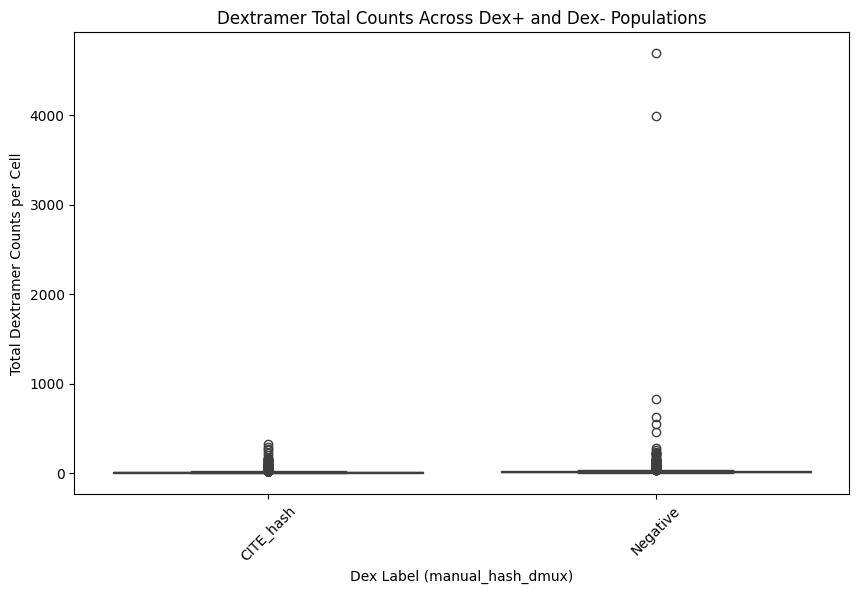

In [ ]:
# Create a boxplot of Dextramer total counts grouped by manual_hash_dmux categories
plt.figure(figsize=(10, 6))
sns.boxplot(data=cdata.obs, x="manual_hash_dmux", y="Dextramer_total_counts")

plt.xlabel("Dex Label (manual_hash_dmux)")
plt.ylabel("Total Dextramer Counts per Cell")
plt.title("Dextramer Total Counts Across Dex+ and Dex- Populations")

plt.xticks(rotation=45)

plt.show()


Plot to check the dextramer counts across cells

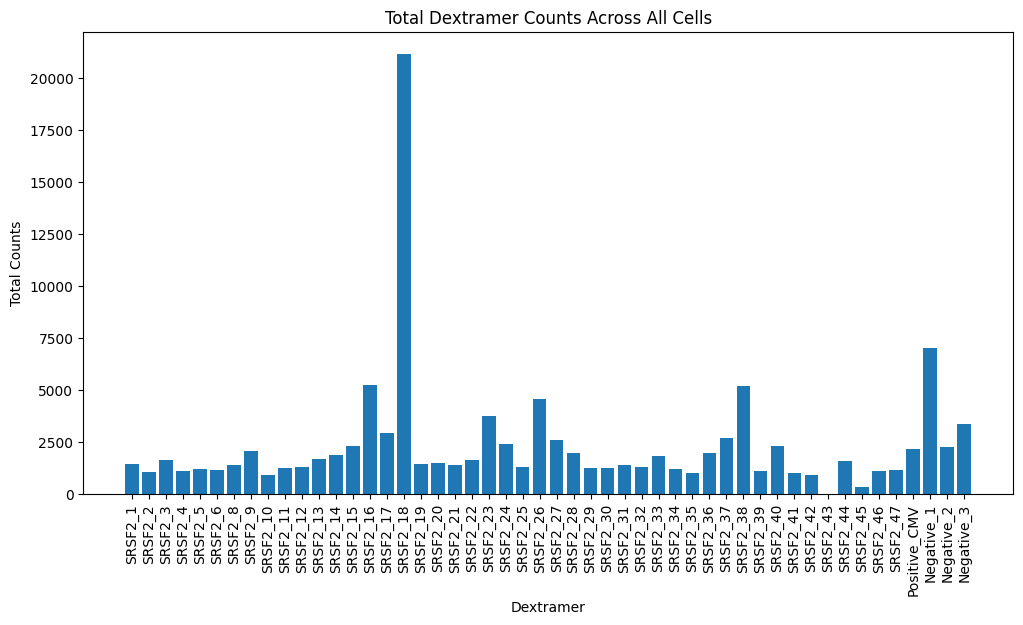

In [10]:
# Sum counts per dextramer across all cells
dextramer_counts = np.array(cdata.obsm["Dextramer"].sum(axis=0)).flatten()

# Plot
plt.figure(figsize=(12, 6))
plt.bar(adata.uns["Dextramer_features"], dextramer_counts)
plt.xticks(rotation=90)
plt.xlabel("Dextramer")
plt.ylabel("Total Counts")
plt.title("Total Dextramer Counts Across All Cells")
plt.show()

### Feature Engineering - Start Building the Feature Set for ML Pipelines

Different features, once calculated, will be stored in anndata

- Background normalization (dextramer signal per cell in Dex+ vs mean Dex- + Log1p)
- Dextramer enrichment (dextramer signal per cell in Dex+ vs mean Dex+)
- Clonotype enrichment in Dex+ vs Dex-
- Clonotype size

In [19]:
def compute_dextramer_features(adata):
    """
    Compute background-normalized and Dex+ enrichment features from dextramer and TCR data.
    Stores results in adata.obsm, adata.obs, and adata.uns.
    """
    # Extract dextramer matrix
    dex_matrix = adata.obsm["Dextramer"].toarray()
    dex_labels = adata.obs["manual_hash_dmux"]

    # Background normalization
    dex_neg_mask = dex_labels == "CITE_hash"
    dex_background = dex_matrix[dex_neg_mask].mean(axis=0)
    dex_fold_change = dex_matrix / (dex_background + 1e-6)
    adata.obsm["Dextramer_norm"] = np.log1p(dex_fold_change)

    # Dex+ enrichment
    dex_pos_mask = dex_labels != "CITE_hash"
    dex_mean_pos = dex_matrix[dex_pos_mask].mean(axis=0)
    dex_enrichment = dex_matrix - dex_mean_pos
    adata.obsm["Dextramer_enrichment"] = dex_enrichment

    # TCR clonotype enrichment
    clonotypes = adata.obs["raw_clonotype_id"]
    dex_pos_mask = dex_labels == "Negative"  # Dex+
    dex_neg_mask = dex_labels == "CITE_hash"  # Dex-
    total_pos = np.sum(dex_pos_mask)
    total_neg = np.sum(dex_neg_mask)

    clono_counts = pd.DataFrame({
        "Dex+ Count": clonotypes[dex_pos_mask].value_counts(),
        "Dex- Count": clonotypes[dex_neg_mask].value_counts()
    }).fillna(0)

    clono_counts["Dex+ Frequency"] = clono_counts["Dex+ Count"] / total_pos
    clono_counts["Dex- Frequency"] = clono_counts["Dex- Count"] / total_neg
    clono_counts["Enrichment Ratio"] = clono_counts["Dex+ Frequency"] / (clono_counts["Dex- Frequency"] + 1e-6)
    clono_counts["Log Enrichment"] = np.log2(clono_counts["Enrichment Ratio"] + 1e-6)

    adata.uns["clonotype_enrichment"] = clono_counts

    # Add per-cell clonotype count to adata.obs
    clonotype_counts = adata.obs["raw_clonotype_id"].value_counts().to_dict()
    adata.obs["clonotype_count"] = adata.obs["raw_clonotype_id"].map(clonotype_counts)

    return adata


Apply function to anndata objects to engineer features

In [20]:
for sample in [adata, bdata, cdata]:
    compute_dextramer_features(sample)

##### Build the Feature Matrix `X`

This section extracts and compiles all engineered features from the `AnnData` object (`adata`) into a unified DataFrame called `X`. This matrix serves as the input for the machine learning pipelines (XGBoost and Isolation Forest). Each row represents a `(cell, dextramer)` pair with features describing signal strength, clonotype context, and enrichment characteristics.



In [ ]:
def build_feature_matrix(adata):
    """
    Build a per-cell, per-dextramer feature matrix from an AnnData object.
    Returns:
        pd.DataFrame: Feature matrix X with cell-level, dextramer-level, and clonotype-level features.
    """
    # Cell-Level Features
    cell_features = adata.obs[["raw_clonotype_id"]].copy()
    clonotype_counts = adata.obs["raw_clonotype_id"].value_counts().to_dict()
    cell_features["clonotype_count"] = cell_features["raw_clonotype_id"].map(clonotype_counts)

    # Dextramer-Level Features
    dex_norm_df = pd.DataFrame(adata.obsm["Dextramer_norm"], index=adata.obs_names)
    dex_enrich_df = pd.DataFrame(adata.obsm["Dextramer_enrichment"], index=adata.obs_names)

    # Melt into long format
    dex_norm_melted = dex_norm_df.reset_index().melt(id_vars="index", var_name="dextramer", value_name="dex_norm")
    dex_enrich_melted = dex_enrich_df.reset_index().melt(id_vars="index", var_name="dextramer", value_name="dex_enrich")

    # Merge dextramer-level features
    dex_features = (
        dex_norm_melted
        .merge(dex_enrich_melted, on=["index", "dextramer"])
    )

    # Merge with cell-level
    X = pd.merge(dex_features, cell_features, left_on="index", right_index=True)

    # Cleanup + fill
    X.rename(columns={"index": "cell_id"}, inplace=True)

    # Handle missing clonotype IDs safely for Categorical dtype
    X["raw_clonotype_id"] = X["raw_clonotype_id"].astype("category")
    if "_no_clonotype_" not in X["raw_clonotype_id"].cat.categories:
        X["raw_clonotype_id"] = X["raw_clonotype_id"].cat.add_categories("_no_clonotype_")
    X["raw_clonotype_id"] = X["raw_clonotype_id"].fillna("_no_clonotype_")

    X["clonotype_count"] = X["clonotype_count"].fillna(0)

    # Map dextramer indices to names
    dex_names = list(adata.uns["Dextramer_features"])
    dex_index_to_name = {i: name for i, name in enumerate(dex_names)}
    X["dextramer"] = X["dextramer"].map(dex_index_to_name)

    # Merge clonotype enrichment
    clono_enrich = adata.uns["clonotype_enrichment"][["Log Enrichment"]].copy()
    clono_enrich.rename(columns={"Log Enrichment": "clonotype_enrichment"}, inplace=True)
    X = X.merge(clono_enrich, left_on="raw_clonotype_id", right_index=True, how="left")
    X["clonotype_enrichment"] = X["clonotype_enrichment"].fillna(0)

    return X


In [ ]:
X_a = build_feature_matrix(adata)
X_b = build_feature_matrix(bdata)
X_c = build_feature_matrix(cdata)

In [41]:
X_a.to_parquet("feature_matrix_X_a.parquet")
X_b.to_parquet("feature_matrix_X_b.parquet")
X_c.to_parquet("feature_matrix_X_c.parquet")

##### XGBoost 

Here we are feeding the known positive control binders in adata as ground truths

In [29]:
# Define known true binding pairs
known_true_pairs = [
    ("Positive_CMV", "clonotype7"),
    ("Positive_CMV", "clonotype39"),
    ("Positive_CMV", "clonotype64"),
]

# Create ground truth label vector
X_a["is_true_binder"] = X_a.apply(
    lambda row: int((row["dextramer"], row["raw_clonotype_id"]) in known_true_pairs),
    axis=1
)

# Confirm label distribution
y = X_a["is_true_binder"]
print("✅ Label distribution (1 = true binder):")
print(y.value_counts())


✅ Label distribution (1 = true binder):
is_true_binder
0    400859
1       241
Name: count, dtype: int64


Defining the model

In [30]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Define feature columns (same as before)
feature_cols = [
    "dex_norm",
    #"dex_rank",
    "dex_enrich",
    #"Top_dextramer_margin",
    "clonotype_count",
    "clonotype_enrichment"
]

# Build feature matrix and target
X_model = X_a[feature_cols]
y = X_a["is_true_binder"]

# Optional: check imbalance
print("Class balance:")
print(y.value_counts())

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_model, y, test_size=0.2, stratify=y, random_state=42
)

# Set scale_pos_weight = ratio of negatives to positives
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Train classifier
xgb_clf = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

xgb_clf.fit(X_train, y_train)

# Predict
y_pred = xgb_clf.predict(X_test)
y_proba = xgb_clf.predict_proba(X_test)[:, 1]

# Evaluate
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, digits=4))



Class balance:
is_true_binder
0    400859
1       241
Name: count, dtype: int64


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:10:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     80172
           1     0.9412    1.0000    0.9697        48

    accuracy                         1.0000     80220
   macro avg     0.9706    1.0000    0.9848     80220
weighted avg     1.0000    1.0000    1.0000     80220



Save the model

In [31]:
import joblib

# Save the trained classifier to a file
joblib.dump(xgb_clf, "xgb_cmv_binder_classifier.pkl")

['xgb_cmv_binder_classifier.pkl']

## Apply the model to bdata and cdata

We know that for bdata (SRSF2_9) that SRSF2_31 binds clonotype 16
cdata is particularly noisy.

In [33]:
X_b_model = X_b[feature_cols]
X_c_model = X_c[feature_cols]

# Predict probabilities (binding scores)
b_proba = xgb_clf.predict_proba(X_b_model)[:, 1]
c_proba = xgb_clf.predict_proba(X_c_model)[:, 1]

# Attach probabilities back to the feature matrices
X_b["binding_score"] = b_proba
X_c["binding_score"] = c_proba

# Get top predicted binder pairs
# Sort by highest probability
top_b = X_b.sort_values(by="binding_score", ascending=False)
top_c = X_c.sort_values(by="binding_score", ascending=False)

def get_top_clonotype_dextramer_predictions(X_df, top_n=10):
    """
    Aggregate binding scores across cells for each (clonotype, dextramer) pair,
    and return the top N with the highest mean binding score.
    """
    agg_df = (
        X_df
        .groupby(["raw_clonotype_id", "dextramer"])
        .agg(
            mean_binding_score=("binding_score", "mean"),
            num_cells=("binding_score", "count")
        )
        .reset_index()
        .sort_values(by="mean_binding_score", ascending=False)
    )
    return agg_df.head(top_n)

top_b_clonotypes = get_top_clonotype_dextramer_predictions(X_b, top_n=10)
top_c_clonotypes = get_top_clonotype_dextramer_predictions(X_c, top_n=10)

print("🔵 Top Clonotype–Dextramer Pairs in bdata:")
print(top_b_clonotypes)

print("\n🟢 Top Clonotype–Dextramer Pairs in cdata:")
print(top_c_clonotypes)


🔵 Top Clonotype–Dextramer Pairs in bdata:
      raw_clonotype_id dextramer  mean_binding_score  num_cells
18028      clonotype16  SRSF2_31            0.567769         57
21387      clonotype17   SRSF2_4            0.064128         51
17890     clonotype157  SRSF2_42            0.053038          5
10386     clonotype132  SRSF2_39            0.044202          6
10761     clonotype133  SRSF2_16            0.044202          6
10355     clonotype132  SRSF2_10            0.044202          6
10395     clonotype132  SRSF2_47            0.044202          6
9943      clonotype131  SRSF2_45            0.044202          6
7145      clonotype124  SRSF2_47            0.044201          6
44488     clonotype734  SRSF2_40            0.019758          1

🟢 Top Clonotype–Dextramer Pairs in cdata:
      raw_clonotype_id   dextramer  mean_binding_score  num_cells
3674      clonotype109    SRSF2_28            0.053038          5
3681      clonotype109    SRSF2_34            0.053038          5
58921      cl

Plot feature contributions

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


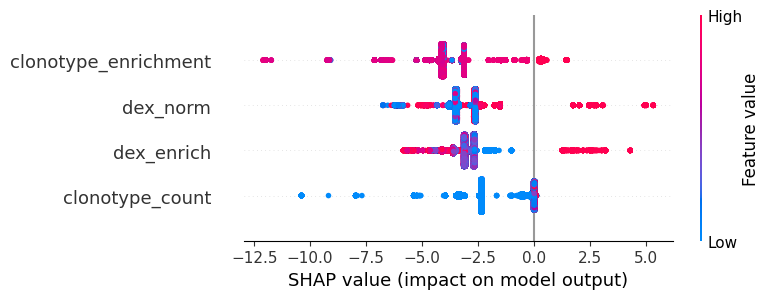

In [35]:
import shap

# Initialize SHAP explainer for your trained XGBoost model
explainer = shap.TreeExplainer(xgb_clf)

# Predict SHAP values for bdata
shap_values = explainer.shap_values(X_b_model)

# Make SHAP summary plot
shap.summary_plot(shap_values, X_b_model, feature_names=feature_cols)


Compare the dex_norm ranks vs the performance of XGBoost

In [39]:
def get_top_clonotype_dextramer_predictions(X_df, top_n=10):
    """
    Aggregate binding scores across cells for each (clonotype, dextramer) pair,
    and return the top N with the highest mean binding score.
    Only include pairs with >5 supporting cells.
    """
    agg_df = (
        X_df
        .groupby(["raw_clonotype_id", "dextramer"])
        .agg(
            mean_binding_score=("binding_score", "mean"),
            num_cells=("binding_score", "count")
        )
        .reset_index()
    )
    agg_df = agg_df[agg_df["num_cells"] > 5]  # Filter here
    agg_df = agg_df.sort_values(by="mean_binding_score", ascending=False)
    return agg_df.head(top_n)

def get_top_dexnorm_predictions(X_df, top_n=10):
    """
    Aggregate dex_norm across cells for each (clonotype, dextramer) pair,
    and return the top N with the highest mean dex_norm.
    Only include pairs with >5 supporting cells.
    """
    agg_df = (
        X_df
        .groupby(["raw_clonotype_id", "dextramer"])
        .agg(
            mean_dex_norm=("dex_norm", "mean"),
            num_cells=("dex_norm", "count")
        )
        .reset_index()
    )
    agg_df = agg_df[agg_df["num_cells"] > 5]  # Filter here
    agg_df = agg_df.sort_values(by="mean_dex_norm", ascending=False)
    return agg_df.head(top_n)

# Top predictions by model
top_b_clonotypes = get_top_clonotype_dextramer_predictions(X_b, top_n=10)
top_c_clonotypes = get_top_clonotype_dextramer_predictions(X_c, top_n=10)

# Top predictions by raw dex_norm
top_b_dexnorm = get_top_dexnorm_predictions(X_b, top_n=10)
top_c_dexnorm = get_top_dexnorm_predictions(X_c, top_n=10)

# Print results
print("🔵 Top Clonotype–Dextramer Pairs by Model in bdata:")
print(top_b_clonotypes)

print("\n🔵 Top Clonotype–Dextramer Pairs by dex_norm in bdata:")
print(top_b_dexnorm)



🔵 Top Clonotype–Dextramer Pairs by Model in bdata:
      raw_clonotype_id dextramer  mean_binding_score  num_cells
18028      clonotype16  SRSF2_31            0.567769         57
21387      clonotype17   SRSF2_4            0.064128         51
10761     clonotype133  SRSF2_16            0.044202          6
10386     clonotype132  SRSF2_39            0.044202          6
10395     clonotype132  SRSF2_47            0.044202          6
9943      clonotype131  SRSF2_45            0.044202          6
10355     clonotype132  SRSF2_10            0.044202          6
7145      clonotype124  SRSF2_47            0.044201          6
18041      clonotype16  SRSF2_43            0.013471         57
18011      clonotype16  SRSF2_16            0.006752         57

🔵 Top Clonotype–Dextramer Pairs by dex_norm in bdata:
      raw_clonotype_id dextramer  mean_dex_norm  num_cells
18028      clonotype16  SRSF2_31       3.423690         57
21387      clonotype17   SRSF2_4       2.134100         51
48315      cl

The top-ranked hit using the XGBoost classifier has a predicted binding score **8.9× higher** than the second-ranked hit.  
In contrast, when ranking by raw normalized dextramer signal (`dex_norm`), the difference between the first and second hits is only **1.6×**.  
This suggests that the machine learning model not only amplifies true binding signal but also **more effectively separates true binders from background noise** compared to ranking by signal strength alone.
